In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
train_df = pd.read_csv('H1full.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,...,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,...,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,...,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,...,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [3]:
# Interval variables
leadtime = train_df['LeadTime']
arrivaldateyear = train_df['ArrivalDateYear']
arrivaldateweekno = train_df['ArrivalDateWeekNumber']
arrivaldatedayofmonth = train_df['ArrivalDateDayOfMonth']
staysweekendnights = train_df['StaysInWeekendNights']
staysweeknights = train_df['StaysInWeekNights']
adults = train_df['Adults']
children = train_df['Children']
babies = train_df['Babies']
isrepeatedguest = train_df['IsRepeatedGuest'] 
previouscancellations = train_df['PreviousCancellations']
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled']
bookingchanges = train_df['BookingChanges']
agent = train_df['Agent']
company = train_df['Company']
dayswaitinglist = train_df['DaysInWaitingList']
adr = train_df['ADR']
rcps = train_df['RequiredCarParkingSpaces']
totalsqr = train_df['TotalOfSpecialRequests']

In [4]:
y1 = np.array(adr)

In [5]:
# Categorical variables
IsCanceled = train_df['IsCanceled']
arrivaldatemonth = train_df.ArrivalDateMonth.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)

In [6]:
x1 = np.column_stack((IsCanceled,countrycat,marketsegmentcat,deposittypecat,customertypecat,rcps,arrivaldateweekno))
x1 = sm.add_constant(x1, prepend=True)

In [7]:
#Variables
y1=np.reshape(y1, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x1))
xscale=scaler_x.transform(x1)
print(scaler_y.fit(y1))
yscale=scaler_y.transform(y1)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [8]:
y1.shape

(40060, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

In [10]:
y_train.shape

(30045, 1)

In [11]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='elu'))
model.add(Dense(1669, activation='elu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1669)              15021     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1670      
Total params: 16,763
Trainable params: 16,763
Non-trainable params: 0
_________________________________________________________________


In [12]:
start = time.time()

In [13]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
history=model.fit(X_train, y_train, epochs=30, batch_size=150,  verbose=1, validation_split=0.2)
predictions = model.predict(X_test)

Epoch 1/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0966 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0933
Epoch 2/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0933 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0930
Epoch 3/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0931 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0920
Epoch 4/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0928 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0929
Epoch 5/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0927 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0926
Epoch 6/30
161/161 [==============================] - 0s 2ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0926 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0920
Epoch 7/30
161/1

In [14]:
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 9.052403450012207s


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


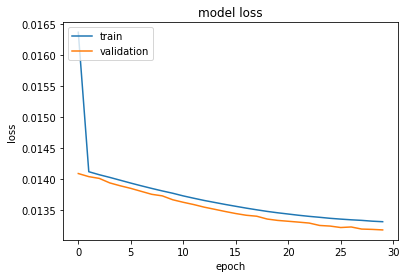

In [15]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
h2data = pd.read_csv('H2full.csv')
a=h2data.head()
a

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [17]:
t_leadtime = h2data['LeadTime'] #1
t_arrivaldateyear = h2data['ArrivalDateYear']
t_arrivaldateweekno = h2data['ArrivalDateWeekNumber']
t_arrivaldatedayofmonth = h2data['ArrivalDateDayOfMonth']
t_staysweekendnights = h2data['StaysInWeekendNights'] #2
t_staysweeknights = h2data['StaysInWeekNights'] #3
t_adults = h2data['Adults'] #4
t_children = h2data['Children'] #5
t_babies = h2data['Babies'] #6
t_isrepeatedguest = h2data['IsRepeatedGuest'] #11
t_previouscancellations = h2data['PreviousCancellations'] #12
t_previousbookingsnotcanceled = h2data['PreviousBookingsNotCanceled'] #13
t_bookingchanges = h2data['BookingChanges'] #16
t_agent = h2data['Agent'] #18
t_company = h2data['Company'] #19
t_dayswaitinglist = h2data['DaysInWaitingList'] #20
t_adr = h2data['ADR'] #22
t_rcps = h2data['RequiredCarParkingSpaces'] #23
t_totalsqr = h2data['TotalOfSpecialRequests'] #24

In [18]:
# Categorical variables
t_IsCanceled = h2data['IsCanceled']
t_arrivaldatemonth = h2data.ArrivalDateMonth.astype("category").cat.codes
t_arrivaldatemonthcat = pd.Series(t_arrivaldatemonth)
t_mealcat=h2data.Meal.astype("category").cat.codes
t_mealcat=pd.Series(t_mealcat)
t_countrycat=h2data.Country.astype("category").cat.codes
t_countrycat=pd.Series(t_countrycat)
t_marketsegmentcat=h2data.MarketSegment.astype("category").cat.codes
t_marketsegmentcat=pd.Series(t_marketsegmentcat)
t_distributionchannelcat=h2data.DistributionChannel.astype("category").cat.codes
t_distributionchannelcat=pd.Series(t_distributionchannelcat)
t_reservedroomtypecat=h2data.ReservedRoomType.astype("category").cat.codes
t_reservedroomtypecat=pd.Series(t_reservedroomtypecat)
t_assignedroomtypecat=h2data.AssignedRoomType.astype("category").cat.codes
t_assignedroomtypecat=pd.Series(t_assignedroomtypecat)
t_deposittypecat=h2data.DepositType.astype("category").cat.codes
t_deposittypecat=pd.Series(t_deposittypecat)
t_customertypecat=h2data.CustomerType.astype("category").cat.codes
t_customertypecat=pd.Series(t_customertypecat)
t_reservationstatuscat=h2data.ReservationStatus.astype("category").cat.codes
t_reservationstatuscat=pd.Series(t_reservationstatuscat)

In [19]:
atest = np.column_stack((t_IsCanceled,t_countrycat,t_marketsegmentcat,t_deposittypecat,t_customertypecat,t_rcps,t_arrivaldateweekno))
atest = sm.add_constant(atest, prepend=True)
btest = t_adr
btest=btest.values

In [20]:
np.shape(atest)

(79330, 8)

In [21]:
scaler_atest = MinMaxScaler()
print(scaler_atest.fit(atest))
ascale=scaler_atest.transform(atest)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [22]:
np.shape(ascale)

(79330, 8)

In [23]:
bpred = model.predict(ascale)
bpred

array([[0.18251371],
       [0.21622771],
       [0.21622771],
       ...,
       [0.20943896],
       [0.20766583],
       [0.20943896]], dtype=float32)

In [24]:
bpred = scaler_y.inverse_transform(bpred)

In [25]:
bpred

array([[ 87.5014 ],
       [104.84321],
       [104.84321],
       ...,
       [101.35122],
       [100.43915],
       [101.35122]], dtype=float32)

In [26]:
btest

array([  0.  ,  76.5 ,  68.  , ..., 157.71, 104.4 , 151.2 ])

In [27]:
np.shape(btest)

(79330,)

In [28]:
np.shape(bpred)

(79330, 1)

In [29]:
bpred=np.reshape(bpred, (79330,)) 

In [30]:
np.shape(bpred)

(79330,)

In [31]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
mean_absolute_error(btest, bpred)

29.154848575524245

In [32]:
mean_squared_error(btest, bpred)

1958.0074665690952

In [33]:
math.sqrt(mean_squared_error(btest, bpred))

44.24937814895363

In [34]:
np.mean(btest)

105.30446539770578

In [35]:
np.mean(bpred)

94.81431